<a href="https://colab.research.google.com/gist/SK124/29364eb2ab7cc5816d5aa9f9e1cac09b/smiles-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/DSPsleeporg/smiles-transformer.git

Cloning into 'smiles-transformer'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 620 (delta 9), reused 6 (delta 2), pack-reused 599
Receiving objects: 100% (620/620), 72.26 MiB | 32.28 MiB/s, done.
Resolving deltas: 100% (417/417), done.


In [ ]:
%cd /content/smiles-transformer/smiles_transformer

/content/smiles-transformer/smiles_transformer


In [ ]:
cp /content/drive/'My Drive'/Miniconda3-latest-Linux-x86_64.sh /content/ 

In [ ]:
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/rdkit')
%cd /usr/local/lib/python3.7/site-packages/

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - cryptography==2.9.2=py37h1ba5d50_0
    - idna==2.9=py_1
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.3=he6710b0_1
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1g=h7b6447c_0
    - pip==20.0.2=py37_3
    - pycosat==0.6.3=py37h7b6447c_0
    - pycparser==2.20=py_0
    - pyopenssl==19.1.0=py37_0
    - pysocks==1.7.1=py37_0
    - python==3.7.7=hcff3b4d_5
    - readline==8.0=h7b6447c_0
    - requests==2.23.0=py37_0
    - ruamel_yaml==0.15.87=py37h7b6447c_0
    - setuptools==

In [ ]:
import re
import os
import pandas as pd
import numpy as np
import random
import pickle
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from tqdm import tqdm

In [ ]:
%cd /content/

/content


In [ ]:
%cd /content/smiles-transformer/smiles_transformer/

/content/smiles-transformer/smiles_transformer


In [ ]:
import argparse
import pandas as pd
from tqdm import tqdm

#from utils import splitsss
def main():
  
    default='/content/drive/My Drive/De NovoDrug/full_data_final.csv'
    smiles = pd.read_csv(default)['col'].values
    with open('chembl24_corpus.txt', 'a') as f:
        for sm in tqdm(smiles):
            f.write(splits(sm)+'\n')
    print('Built a corpus file!')

if __name__=='__main__':
    main()





  0%|          | 0/100000 [00:00<?, ?it/s]

  2%|▏         | 2482/100000 [00:00<00:03, 24816.95it/s]

  4%|▍         | 4463/100000 [00:00<00:04, 23064.81it/s]

  7%|▋         | 6837/100000 [00:00<00:04, 23261.42it/s]

  9%|▉         | 9003/100000 [00:00<00:03, 22754.47it/s]

 11%|█         | 11180/100000 [00:00<00:03, 22449.74it/s]

 13%|█▎        | 13469/100000 [00:00<00:03, 22578.46it/s]

 16%|█▌        | 15858/100000 [00:00<00:03, 22954.54it/s]

 18%|█▊        | 18245/100000 [00:00<00:03, 23220.71it/s]

 21%|██        | 20570/100000 [00:00<00:03, 23229.03it/s]

 23%|██▎       | 22948/100000 [00:01<00:03, 23388.78it/s]

 25%|██▌       | 25257/100000 [00:01<00:03, 23296.85it/s]

 28%|██▊       | 27540/100000 [00:01<00:03, 22064.17it/s]

 30%|██▉       | 29912/100000 [00:01<00:03, 22535.31it/s]

 32%|███▏      | 32249/100000 [00:01<00:02, 22777.96it/s]

 35%|███▍      | 34520/100000 [00:01<00:02, 22660.77it/s]

 37%|███▋      | 36782/100000 [00:01<00:02, 22569.91it/s]

 39%|███▉     

Built a corpus file!


In [ ]:
import torch
import math
import torch.nn as nn
from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.*')

# Split SMILES into words
def splits(sm):
    '''
    function: Split SMILES into words. Care for Cl, Br, Si, Se, Na etc.
    input: A SMILES
    output: A string with space between words
    '''
    arr = []
    i = 0
    while i < len(sm)-1:
        if not sm[i] in ['%', 'C', 'B', 'S', 'N', 'R', 'X', 'L', 'A', 'M', \
                        'T', 'Z', 's', 't', 'H', '+', '-', 'K', 'F']:
            arr.append(sm[i])
            i += 1
        elif sm[i]=='%':
            arr.append(sm[i:i+3])
            i += 3
        elif sm[i]=='C' and sm[i+1]=='l':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='C' and sm[i+1]=='a':
            arr.append(sm[i:i+2])

            i += 2
        elif sm[i]=='C' and sm[i+1]=='u':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='B' and sm[i+1]=='r':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='B' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='B' and sm[i+1]=='a':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='B' and sm[i+1]=='i':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='S' and sm[i+1]=='i':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='S' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='S' and sm[i+1]=='r':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='N' and sm[i+1]=='a':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='N' and sm[i+1]=='i':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='R' and sm[i+1]=='b':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='R' and sm[i+1]=='a':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='X' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='L' and sm[i+1]=='i':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='A' and sm[i+1]=='l':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='A' and sm[i+1]=='s':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='A' and sm[i+1]=='g':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='A' and sm[i+1]=='u':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='M' and sm[i+1]=='g':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='M' and sm[i+1]=='n':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='T' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='Z' and sm[i+1]=='n':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='s' and sm[i+1]=='i':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='s' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='t' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='H' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='+' and sm[i+1]=='2':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='+' and sm[i+1]=='3':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='+' and sm[i+1]=='4':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='-' and sm[i+1]=='2':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='-' and sm[i+1]=='3':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='-' and sm[i+1]=='4':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='K' and sm[i+1]=='r':
            arr.append(sm[i:i+2])
            i += 2
        elif sm[i]=='F' and sm[i+1]=='e':
            arr.append(sm[i:i+2])
            i += 2
        else:
            arr.append(sm[i])
            i += 1
    if i == len(sm)-1:
        arr.append(sm[i])
    return ' '.join(arr) 

# 活性化関数
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

# 位置情報を考慮したFFN
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))
    
# 正規化層
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

# Sample SMILES from probablistic distribution
def sample(msms):
    ret = []
    for msm in msms:
        ret.append(torch.multinomial(msm.exp(), 1).squeeze())
    return torch.stack(ret)

def validity(smiles):
    loss = 0
    for sm in smiles:
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            loss += 1
    return 1-loss/len(smiles)



In [ ]:
import argparse
import pickle
from collections import Counter


class TorchVocab(object):
    """
    :property freqs: collections.Counter, コーパス中の単語の出現頻度を保持するオブジェクト
    :property stoi: collections.defaultdict, string → id の対応を示す辞書
    :property itos: collections.defaultdict, id → string の対応を示す辞書
    """
    def __init__(self, counter, max_size=None, min_freq=1, specials=['<pad>', '<oov>'],
                 vectors=None, unk_init=None, vectors_cache=None):
        """
        :param counter: collections.Counter, データ中に含まれる単語の頻度を計測するためのcounter
        :param max_size: int, vocabularyの最大のサイズ. Noneの場合は最大値なし. defaultはNone
        :param min_freq: int, vocabulary中の単語の最低出現頻度. この数以下の出現回数の単語はvocabularyに加えられない.
        :param specials: list of str, vocabularyにあらかじめ登録するtoken
        :param vectors: list of vectors, 事前学習済みのベクトル. ex)Vocab.load_vectors
        """
        self.freqs = counter
        counter = counter.copy()
        min_freq = max(min_freq, 1)

        self.itos = list(specials)
        # special tokensの出現頻度はvocabulary作成の際にカウントされない
        for tok in specials:
            del counter[tok]

        max_size = None if max_size is None else max_size + len(self.itos)

        # まず頻度でソートし、次に文字順で並び替える
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)
        
        # 出現頻度がmin_freq未満のものはvocabに加えない
        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:
                break
            self.itos.append(word)

        # dictのk,vをいれかえてstoiを作成する
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.vectors = None
        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init, cache=vectors_cache)
        else:
            assert unk_init is None and vectors_cache is None

    def __eq__(self, other):
        if self.freqs != other.freqs:
            return False
        if self.stoi != other.stoi:
            return False
        if self.itos != other.itos:
            return False
        if self.vectors != other.vectors:
            return False
        return True

    def __len__(self):
        return len(self.itos)

    def vocab_rerank(self):
        self.stoi = {word: i for i, word in enumerate(self.itos)}

    def extend(self, v, sort=False):
        words = sorted(v.itos) if sort else v.itos
        for w in words:
            if w not in self.stoi:
                self.itos.append(w)
                self.stoi[w] = len(self.itos) - 1


class Vocab(TorchVocab):
    def __init__(self, counter, max_size=None, min_freq=1):
        self.pad_index = 0
        self.unk_index = 1
        self.eos_index = 2
        self.sos_index = 3
        self.mask_index = 4
        super().__init__(counter, specials=["<pad>", "<unk>", "<eos>", "<sos>", "<mask>"], max_size=max_size, min_freq=min_freq)

    # override用
    def to_seq(self, sentece, seq_len, with_eos=False, with_sos=False) -> list:
        pass

    # override用
    def from_seq(self, seq, join=False, with_pad=False):
        pass

    @staticmethod
    def load_vocab(vocab_path: str) -> 'Vocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)


# テキストファイルからvocabを作成する
class WordVocab(Vocab):
    def __init__(self, texts, max_size=None, min_freq=1):
        print("Building Vocab")
        counter = Counter()
        for line in texts:
            if isinstance(line, list):
                words = line
            else:
                words = line.replace("\n", "").replace("\t", "").split()

            for word in words:
                counter[word] += 1
        super().__init__(counter, max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentence, seq_len=None, with_eos=False, with_sos=False, with_len=False):
        if isinstance(sentence, str):
            sentence = sentence.split()

        seq = [self.stoi.get(word, self.unk_index) for word in sentence]

        if with_eos:
            seq += [self.eos_index]  # this would be index 1
        if with_sos:
            seq = [self.sos_index] + seq

        origin_seq_len = len(seq)

        if seq_len is None:
            pass
        elif len(seq) <= seq_len:
            seq += [self.pad_index for _ in range(seq_len - len(seq))]
        else:
            seq = seq[:seq_len]

        return (seq, origin_seq_len) if with_len else seq

    def from_seq(self, seq, join=False, with_pad=False):
        words = [self.itos[idx]
                 if idx < len(self.itos)
                 else "<%d>" % idx
                 for idx in seq
                 if not with_pad or idx != self.pad_index]

        return " ".join(words) if join else words

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)


def main():

    with open('/content/smiles-transformer/smiles_transformer/chembl24_corpus.txt', "r", encoding='utf-8') as f:
        vocab = WordVocab(f, max_size=None, min_freq=500)

    print("VOCAB SIZE:", len(vocab))
    #vocab.save_vocab('vocab2.txt')
    vocab.save_vocab('vocab2.pkl')

if __name__=='__main__':
    main()

Building Vocab
VOCAB SIZE: 33


In [ ]:
df=pd.read_csv('/content/smiles-transformer/smiles_transformer/gdb08_bert_train.csv')
df.head()

,canonical_smiles
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(C(=O)NC(C)C(=O)NC(C...
1,Cc1c(NC2CC2)nc(C2CC2)nc1N1CCC(C(F)(F)F)CC1
2,CN1CCC(=C2c3ccccc3Oc3ccccc32)CC1
3,CCSc1nsnc1OC1CN2CCC1CC2
4,N#Cc1c(NCc2ccc(Cl)cc2)nn2c(=O)cc(Cc3ccccc3)[nH...


In [ ]:
python pretrain_trfm.py

Traceback (most recent call last):
  File "pretrain_trfm.py", line 7, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


In [ ]:
import torch
sm=torch.ones(2,2)
v=sm.contiguous().view(-1)
v.shape

torch.Size([4])

In [ ]:
output=torch.randn(2,2,3)
output.view(-1, 3)

tensor([[-1.4751, -2.1334, -1.8683],
        [-1.7801,  0.1868, -0.7243],
        [ 1.8142, -1.1209,  1.6500],
        [-0.0722,  1.5646,  1.6088]])

In [ ]:

import torch.nn.functional as F
loss = F.nll_loss(output.view(-1, 3),sm.contiguous().view(-1).long())
loss

tensor(0.3757)

In [ ]:
loss

tensor(-1.)

In [ ]:
import argparse
import math
import os

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from build_vocab import WordVocab
from dataset import Seq2seqDataset

PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4

class PositionalEncoding(nn.Module):
    "Implement the PE function. No batch support?"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model) # (T,H)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

class TrfmSeq2seq(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_layers, dropout=0.1):
        super(TrfmSeq2seq, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(in_size, hidden_size)
        self.pe = PositionalEncoding(hidden_size, dropout)
        self.trfm = nn.Transformer(d_model=hidden_size, nhead=4, 
        num_encoder_layers=n_layers, num_decoder_layers=n_layers, dim_feedforward=hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, src):
        # src: (T,B)
        embedded = self.embed(src)  # (T,B,H)
        embedded = self.pe(embedded) # (T,B,H)
        hidden = self.trfm(embedded, embedded) # (T,B,H)
        out = self.out(hidden) # (T,B,V)
        out = F.log_softmax(out, dim=2) # (T,B,V)
        return out # (T,B,V)

    def _encode(self, src):
        # src: (T,B)
        embedded = self.embed(src)  # (T,B,H)
        embedded = self.pe(embedded) # (T,B,H)
        output = embedded
        for i in range(self.trfm.encoder.num_layers - 1):
            output = self.trfm.encoder.layers[i](output, None)  # (T,B,H)
        penul = output.detach().numpy()
        output = self.trfm.encoder.layers[-1](output, None)  # (T,B,H)
        if self.trfm.encoder.norm:
            output = self.trfm.encoder.norm(output) # (T,B,H)
        output = output.detach().numpy()
        # mean, max, first*2
        return np.hstack([np.mean(output, axis=0), np.max(output, axis=0), output[0,:,:], penul[0,:,:] ]) # (B,4H)
    
    def encode(self, src):
        # src: (T,B)
        batch_size = src.shape[1]
        if batch_size<=100:
            return self._encode(src)
        else: # Batch is too large to load
            print('There are {:d} molecules. It will take a little time.'.format(batch_size))
            st,ed = 0,100
            out = self._encode(src[:,st:ed]) # (B,4H)
            while ed<batch_size:
                st += 100
                ed += 100
                out = np.concatenate([out, self._encode(src[:,st:ed])], axis=0)
            return out

def parse_arguments():
    parser = argparse.ArgumentParser(description='Hyperparams')
    parser.add_argument('--n_epoch', '-e', type=int, default=5, help='number of epochs')
    parser.add_argument('--vocab', '-v', type=str, default='data/vocab.pkl', help='vocabulary (.pkl)')
    parser.add_argument('--data', '-d', type=str, default='data/chembl_25.csv', help='train corpus (.csv)')
    parser.add_argument('--out-dir', '-o', type=str, default='../result', help='output directory')
    parser.add_argument('--name', '-n', type=str, default='ST', help='model name')
    parser.add_argument('--seq_len', type=int, default=220, help='maximum length of the paired seqence')
    parser.add_argument('--batch_size', '-b', type=int, default=8, help='batch size')
    parser.add_argument('--n_worker', '-w', type=int, default=16, help='number of workers')
    parser.add_argument('--hidden', type=int, default=256, help='length of hidden vector')
    parser.add_argument('--n_layer', '-l', type=int, default=4, help='number of layers')
    parser.add_argument('--n_head', type=int, default=4, help='number of attention heads')
    parser.add_argument('--lr', type=float, default=1e-4, help='Adam learning rate')
    parser.add_argument('--gpu', metavar='N', type=int, nargs='+', help='list of GPU IDs to use')
    return parser.parse_args()




def evaluate(model, test_loader, vocab):
    model.eval()
    total_loss = 0
    for b, sm in enumerate(test_loader):
        sm = torch.t(sm.cuda()) # (T,B)
        with torch.no_grad():
            output = model(sm) # (T,B,V)
        loss = F.nll_loss(output.view(-1, len(vocab)),
                               sm.contiguous().view(-1),
                               ignore_index=PAD)
        total_loss += loss.item()
    return total_loss / len(test_loader)

def main():
    #args = parse_arguments()
    assert torch.cuda.is_available()

    print('Loading dataset...')
    vocab = WordVocab.load_vocab('/content/drive/My Drive/vocab.pkl')
    dataset = Seq2seqDataset(pd.read_csv('/content/drive/My Drive/De NovoDrug/full_data_final.csv')['col'].values, vocab)
    test_size = 10000
    train, test = torch.utils.data.random_split(dataset, [len(dataset)-test_size, test_size])
    train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=16)
    test_loader = DataLoader(test, batch_size=8, shuffle=False, num_workers=16)
    print('Train size:', len(train))
    print('Test size:', len(test))
    del dataset, train, test

    model = TrfmSeq2seq(len(vocab), 256, len(vocab), 4).cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    print(model)
    print('Total parameters:', sum(p.numel() for p in model.parameters()))

    best_loss = None
    for e in range(1, 2):
        for b, sm in tqdm(enumerate(train_loader)):
            sm = torch.t(sm.cuda()) # (T,B)
            optimizer.zero_grad()
            output = model(sm) # (T,B,V)
            loss = F.nll_loss(output.view(-1, len(vocab)),
                    sm.contiguous().view(-1), ignore_index=PAD)
            loss.backward()
            optimizer.step()
            if b%1000==0:
                print('Train {:3d}: iter {:5d} | loss {:.3f} | ppl {:.3f}'.format(e, b, loss.item(), math.exp(loss.item())))
            if b%10000==0:
                loss = evaluate(model, test_loader, vocab)
                print('Val {:3d}: iter {:5d} | loss {:.3f} | ppl {:.3f}'.format(e, b, loss, math.exp(loss)))
                # Save the model if the validation loss is the best we've seen so far.
                if not best_loss or loss < best_loss:
                    print("[!] saving model...")
                    if not os.path.isdir(".save"):
                        os.makedirs(".save")
                    torch.save(model.state_dict(), './.save/trfm_new_%d_%d.pkl' % (e,b))
                    best_loss = loss


if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt as e:
        print("[STOP]", e)




Loading dataset...
Train size: 90000
Test size: 10000
TrfmSeq2seq(
  (embed): Embedding(45, 256)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (trfm): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear


0it [00:00, ?it/s]

Train   1: iter     0 | loss 3.911 | ppl 49.932



1it [00:37, 37.95s/it]
2it [00:38, 26.61s/it]

Val   1: iter     0 | loss 3.356 | ppl 28.675
[!] saving model...



3it [00:38, 18.66s/it]
4it [00:38, 13.10s/it]
5it [00:38,  9.20s/it]
6it [00:38,  6.47s/it]
7it [00:38,  4.57s/it]
8it [00:38,  3.23s/it]
9it [00:38,  2.29s/it]
10it [00:38,  1.63s/it]
11it [00:39,  1.18s/it]
12it [00:39,  1.17it/s]
13it [00:39,  1.58it/s]
14it [00:39,  2.11it/s]
15it [00:39,  2.73it/s]
16it [00:39,  3.47it/s]
17it [00:39,  4.30it/s]
18it [00:39,  5.14it/s]
19it [00:39,  6.00it/s]
20it [00:40,  6.80it/s]
21it [00:40,  7.34it/s]
22it [00:40,  7.92it/s]
23it [00:40,  8.19it/s]
24it [00:40,  8.60it/s]
25it [00:40,  8.82it/s]
26it [00:40,  9.08it/s]
27it [00:40,  9.08it/s]
28it [00:40,  9.20it/s]
29it [00:40,  9.28it/s]
30it [00:41,  9.30it/s]
31it [00:41,  9.34it/s]
32it [00:41,  9.34it/s]
33it [00:41,  9.41it/s]
34it [00:41,  9.45it/s]
35it [00:41,  9.58it/s]
36it [00:41,  9.48it/s]
37it [00:41,  9.41it/s]
38it [00:41,  9.44it/s]
39it [00:42,  9.35it/s]
40it [00:42,  9.40it/s]
41it [00:42,  9.41it/s]
42it [00:42,  9.44it/s]
43it [00:42,  9.60it/s]
44it [00:42,  9.39it/s

[STOP] 


In [ ]:
print(os.listdir)

<built-in function listdir>


In [ ]:
import sys
from io import StringIO
from IPython import get_ipython


class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit 

In [ ]:

import argparse
import numpy as np
import pandas as pd

def main():
    parser = argparse.ArgumentParser(description='Convert smi file to csv file')
    parser.add_argument('--in_path', '-i', type=str, default='data/GDB/GDB08.smi', help='input file')
    parser.add_argument('--out_path_1', '-o1', type=str, default='data/gdb08_bert_train.csv', help='output file (train)')
    parser.add_argument('--out_path_2', '-o2', type=str, default='data/gdb08_bert_test.csv', help='output file (test)')
    parser.add_argument('--max', '-m', type=int, default=2e6, help='Maximum number of molecules')
   #args = parser.parse_args()
    print('Input file: {}'.format('/content/drive/My Drive/De NovoDrug/chembl24_cleaned_unique_canon.txt'))
    print('Start preprocessing')

    smiles = []
    with open('/content/drive/My Drive/De NovoDrug/chembl24_cleaned_unique_canon.txt') as f:
        lines = f.readlines()
    for l in lines:
        smiles.append(l.replace('\n', ''))
    del lines
    smiles = np.array(smiles)
    N = len(smiles)
    print('The dataset contains {} molecules'.format(N))
    
    rands = np.random.choice(N, min(N,256), replace=False)
    smiles_train = smiles[rands[:N//2]]
    df_train = pd.DataFrame(data=smiles_train, columns=['canonical_smiles'])
    df_train.to_csv('gdb08_bert_train.csv', index=False)
    del smiles_train, df_train
    smiles_test = smiles[rands[N//2:]]
    df_test = pd.DataFrame(data=smiles_test, columns=['canonical_smiles'])
    df_test.to_csv('gdb08_bert_test.csv', index=False)
    print('Each set contains {} molecules'.format(N//2))

if __name__=='__main__':
    main()



Input file: /content/drive/My Drive/De NovoDrug/chembl24_cleaned_unique_canon.txt
Start preprocessing
The dataset contains 369860 molecules
Each set contains 184930 molecules


In [ ]:
pip in

In [ ]:
%cd /content

/content


In [ ]:
trfm

TrfmSeq2seq(
  (embed): Embedding(45, 256)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (trfm): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
       

In [ ]:
vocab

In [ ]:
import torch
pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('/content/drive/My Drive/vocab (1).pkl')

trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('/content/drive/My Drive/trfm.pkl'))
trfm.eval()
print('Total parameters:', sum(p.numel() for p in trfm.parameters()))

Total parameters: 4245037


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [ ]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

def extract_morgan(smiles, targets):
    x,X,y = [],[],[]
    for sm,target in zip(smiles,targets):
        mol = Chem.MolFromSmiles(sm)
        if mol is None:
            print(sm)
            continue
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        x.append(sm)
        X.append(bit2np(fp))
        y.append(target)
    return x,np.array(X),np.array(y)

In [ ]:
!git clone https://github.com/deepchem/deepchem.git

Cloning into 'deepchem'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 34834 (delta 147), reused 156 (delta 107), pack-reused 34618
Receiving objects: 100% (34834/34834), 440.63 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (25745/25745), done.


In [ ]:
df = pd.read_csv('/content/deepchem/examples/hiv/HIV.csv')
print(df.shape)
df.head()

(41913, 3)


,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


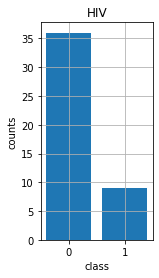

In [ ]:
df_large = df[np.array(list(map(len, df['smiles'])))>218]

keys = ['0', '1']
bottom = df_large.groupby('HIV_active').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

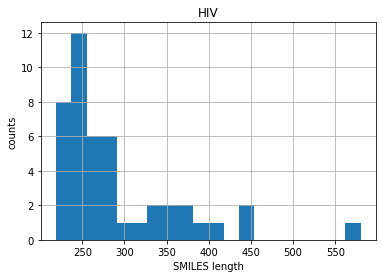

In [ ]:
plt.hist(list(map(len, df_large['smiles'].values)), bins=20)
plt.xlabel('SMILES length')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

In [ ]:
df_train = df[np.array(list(map(len, df['smiles'])))<=218]
df_test = df[np.array(list(map(len, df['smiles'])))>218]

In [ ]:
df_train.shape

(41868, 3)

In [ ]:
def ablation_hiv(X, X_test, y, y_test, rate, n_repeats):
    auc = np.empty(n_repeats)
    for i in range(n_repeats):
        clf = MLPClassifier(max_iter=1000)
        if rate==1:
            X_train, y_train = X,y
        else:
            X_train, _, y_train, __ = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        auc[i] = roc_auc_score(y_test, y_score[:,1])
    ret = {}
    ret['auc mean'] = np.mean(auc)
    ret['auc std'] = np.std(auc)
    return ret

In [ ]:
x_split = [splits(sm) for sm in df_train['smiles'].values]
xid, _ = get_array(x_split)
X = trfm.encode(torch.t(xid))
print(X.shape)
x_split = [splits(sm) for sm in df_test['smiles'].values]
xid, _ = get_array(x_split)
X_test = trfm.encode(torch.t(xid))
print(X_test.shape)
y, y_test = df_train['HIV_active'].values, df_test['HIV_active'].values

There are 41868 molecules. It will take a little time.
(41868, 1024)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES

In [ ]:
scores = []
for rate in rates:
    score_dic = ablation_hiv(X, X_test, y, y_test, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

0.0125 {'auc mean': 0.586111111111111, 'auc std': 0.12544274585413737}
0.025 {'auc mean': 0.5390432098765432, 'auc std': 0.10447553659000973}
0.05 {'auc mean': 0.5945987654320988, 'auc std': 0.11715504205531173}
0.1 {'auc mean': 0.5652777777777777, 'auc std': 0.12755271450619823}
0.2 {'auc mean': 0.6206790123456789, 'auc std': 0.14588321375706326}
0.4 {'auc mean': 0.7348765432098766, 'auc std': 0.09442073857252123}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:

score_dic = ablation_hiv(X, X_test, y, y_test, 1, 20)
print(score_dic)

In [ ]:
x,X,y = extract_morgan(df_train['smiles'].values, df_train['HIV_active'].values)
print(len(X), len(y))
x,X_test,y_test = extract_morgan(df_test['smiles'].values, df_test['HIV_active'].values)
print(len(X_test), len(y_test))

In [ ]:
scores = []
for rate in rates:
    score_dic = ablation_hiv(X, X_test, y, y_test, rate, 20)
    print(rate, score_dic)
    scores.append(score_dic['auc mean'])
print(np.mean(scores))

In [ ]:
score_dic = ablation_hiv(X, X_test, y, y_test, 1, 20)
print(score_dic)